# Processing TikTok Post Data

In [74]:
# ! pip install pandas
# ! pip install matplotlib
# ! pip install gensim

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import numpy as np
from PIL import Image
import re
from wordsegment import load, segment
from gensim.models import Word2Vec
from sklearn.preprocessing import FunctionTransformer
import seaborn as sns
from sklearn.preprocessing import RobustScaler, MinMaxScaler

In [76]:
df = pd.read_csv("../../rawData/TikTok/testPostInput.csv")

df.head()

,id,create_time,user_name,hashtags,song,video_length,n_likes,n_shares,n_comments,n_plays,n_followers,n_total_likes,n_total_vids
0,6892519502127320322,1604789755,robertdowneyjnrofficial,"['summer', 'avengers', 'ohnanana', 'robertdown...",Capone - Oh No,9,2698,4,230,17300,651100,144000,3
1,6882945622962375942,1602560714,jackblack,[],original sound,8,3900000,59100,72300,17700000,3600000,16200000,16
2,6861708313474731270,1597615969,vindieselbrasileiro,"['viral', 'diadossolteiros', 'resort', 'challe...",som original,19,16800,75,302,338300,1700000,4200000,22
3,6892508421405281542,1604787205,chars...alien,"['fypシforyoupage', 'fyptiktok', 'fyp', 'fypps'...",original sound,8,708,23,48,3542,26200,73800,600
4,6892537706161769729,1604793994,tiktokforyouvids,[],original sound,13,966,1,8,4438,3700000,116800000,2377


#### Remove Irrelevant Data 

In [77]:
df.drop(['id', 'user_name', 'song', 'video_length', 'n_total_vids'], axis=1, inplace=True)

### Processing Time

In [78]:
df['datetime'] = pd.to_datetime(df['create_time'], unit='s')
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['weekday'] = df['datetime'].dt.weekday
df['hour'] = df['datetime'].dt.hour

##### Cyclical Encoding of Post's Publish Date

In [79]:
def cyclicSinEncoding(timePeriod):
    encoding = FunctionTransformer(lambda x: np.sin(x / timePeriod * 2 * np.pi))
    return encoding 

def cyclicCosEncoding(timePeriod):
    encoding = FunctionTransformer(lambda x: np.cos(x / timePeriod * 2 * np.pi))
    return encoding 

df['monthSin'] = cyclicSinEncoding(12).fit_transform(df["month"])
df['monthCos'] = cyclicCosEncoding(12).fit_transform(df["month"])

df['daySin'] = cyclicSinEncoding(31).fit_transform(df['day'])
df['dayCos'] = cyclicCosEncoding(31).fit_transform(df['day'])

df['hourSin'] = cyclicSinEncoding(24).fit_transform(df['hour'])
df['hourCos'] = cyclicCosEncoding(24).fit_transform(df['hour'])

df['weekdaySin'] = cyclicSinEncoding(7).fit_transform(df['weekday'])
df['weekdayCos'] = cyclicCosEncoding(7).fit_transform(df['weekday'])

df.drop(['weekday', 'hour', 'month', 'day', 'datetime', 'create_time'], axis=1, inplace=True)

### Processing Hashtags

#### Handle NaN Data

In [80]:
# Convert hashtags to string 

df['hashtags'] = df['hashtags'].apply(ast.literal_eval)
df['hashtags'] = df['hashtags'].apply(lambda x: x if x != [] else ["nohashtag"])

def processHashtags(hashtags):
    for i in range(len(hashtags)):
        if not hashtags[i].strip(): 
            hashtags[i] = 'nohashtag'
    return hashtags

df['hashtags'] = df['hashtags'].apply(processHashtags)
explodedDf = df['hashtags'].explode()

#### Remove Special Characters

In [81]:
def removeSpecialCharacters(hashtags):
    processedHashtag = [re.sub(r'[^a-zA-Z0-9]', '', hashtag) for hashtag in hashtags]
    processedHashtag = [hashtag.lower() for hashtag in processedHashtag]
    return processedHashtag

df['hashtags'] = df['hashtags'].apply(removeSpecialCharacters)

#### Handling Similar Hashtags

In [82]:
def processSimilarHashtags(hashtags):
    similarHashtags = ['fypforyoupage', 'fyp', 'foryou', 'foru', 'foruyou', 'fouryou', 'foryourpage', 'foryouu', 'foryoupag', '4you', 'fypforyou', 'foryoupagee', 'fouryoupage', 'fypforyourpage', 'foreyou', 'foreyoupage', 'foryour', 'foyou', 'fouyoupage' 'foryourpag', '4youpage', 'fypforyoupa', 'foryoupqge', 'fouryoupag', 'foryoupge', 'foyoupage', 'foryouoage', 'foryoyoupage', 'foreyourpage', 'foryourpages', 'fy']
    
    for i in range(len(hashtags)):
        
        if hashtags[i] in similarHashtags:
            hashtags[i] = 'foryoupage'
        
        if not hashtags[i].strip():
            hashtags[i] = 'nohashtag'
    return hashtags

df['hashtags'] = df['hashtags'].apply(processSimilarHashtags)

In [83]:
explodedDf = df['hashtags'].explode()

#### Split Words in Hashtag

In [84]:
def splitHashtagByWords(hashtags):
    wordsToIgnore = ['tiktok']
    splitHashtags = []
    for hashtag in hashtags:
        if hashtag in wordsToIgnore:
             splitHashtags.append([hashtag])
        else:    
            splitHashtags.append(segment(hashtag))
    return splitHashtags

load()
splitHashtags = df['hashtags'].apply(splitHashtagByWords)

processedHashtag = []
for hashtag in splitHashtags:
    for tag in hashtag:
        processedHashtag.append(tag)

#### Encode Hashtags using Word2Vec

In [85]:
model = Word2Vec(sentences=processedHashtag, vector_size=200, window=5, min_count=1, sg=1, workers=4)

model.save("hashtags_word2vec.model")

def encodeHashtag(hashtag):
    
    if any(word in model.wv.key_to_index for word in hashtag):
        vector = sum(model.wv[word] for word in hashtag if word in model.wv) / len(hashtag)
        return vector
    else:
        # If word, can't be found return 0
        return np.zeros(model.vector_size)

def encodeHashtagArray(hashtags):
    vectors = []
    for hashtag in hashtags:
        vector = encodeHashtag(hashtag)
        vectors.append(vector)
    
    if vectors:
        return np.mean(vectors, axis=0)
    else: 
        return np.zeros(model.vector_size)
    
df['hashtagVectors'] = df['hashtags'].apply(encodeHashtagArray)

### Processing Outliers

### Data Scaling

In [86]:
def calculateStatMeasures(col):
    print(f'{col}: mean={df[col].mean()}, median={df[col].median()}, mode={df[col].mode()}, std={df[col].std()}')

def plotData(xLabel, yLabel, x, y, title):
    plt.scatter(x, y, s=3)
    plt.title(title)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.show()

In [87]:
minMaxScaler = MinMaxScaler()

df['nLikesLog'] = np.log1p(df['n_likes'])
df['nSharesLog'] = np.log1p(df['n_shares'])
df['nFollowersLog'] = np.log1p(df['n_followers'])
df['nCommentsLog'] = np.log1p(df['n_comments'])
df['nViewsLog'] = np.log1p(df['n_plays'])
df['nAccountTotalLikesLog'] = np.log1p(df['n_total_likes'])
df['nFollowersLog'] = np.log1p(df['n_followers']) 

df[['nLikes', 'nShares', 'nFollowers', 'nComments', 'nViews', 'nAccountTotalLikes', 'nFollowers', 'postYear']] = minMaxScaler.fit_transform(df[['nLikesLog', 'nSharesLog', 'nFollowersLog', 'nCommentsLog', 'nViewsLog', 'nAccountTotalLikesLog', 'nFollowersLog', 'year']])

In [88]:
df.drop(['n_shares', 'n_likes', 'n_comments', 'n_plays', 'n_followers','n_total_likes', 'hashtags', 'year', 'nLikesLog', 'nSharesLog', 'nFollowersLog', 'nCommentsLog', 'nViewsLog', 'nAccountTotalLikesLog', 'nFollowersLog'], axis=1, inplace=True)

#### Plot Data

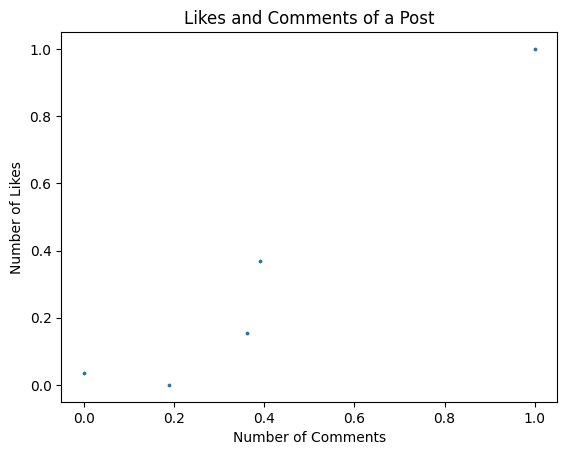

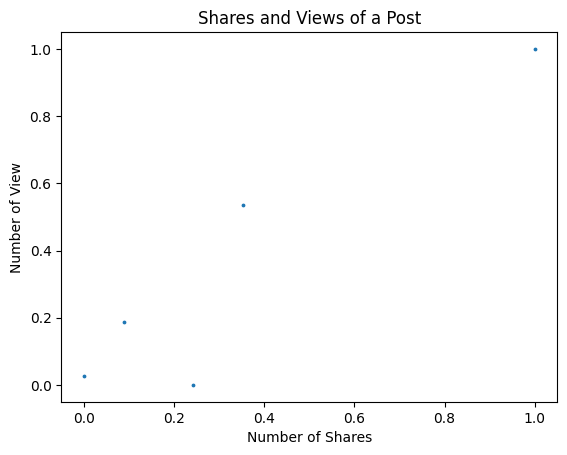

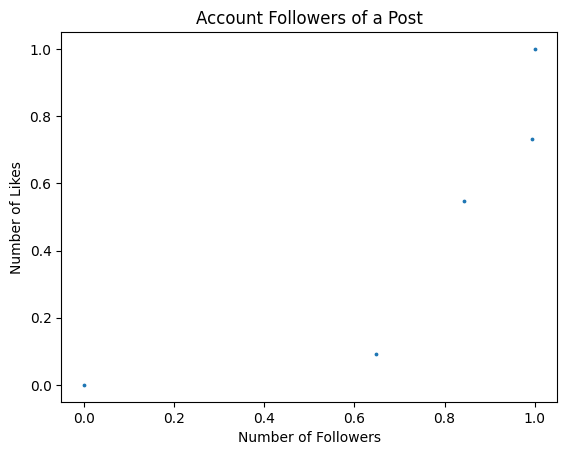

In [89]:
plotData('Number of Comments', 'Number of Likes', df['nComments'], df['nLikes'], 'Likes and Comments of a Post')
plotData('Number of Shares', 'Number of View', df['nShares'], df['nViews'], 'Shares and Views of a Post')
plotData('Number of Followers', 'Number of Likes', df['nFollowers'], df['nAccountTotalLikes'], 'Account Followers of a Post')

In [90]:
df.head()

,monthSin,monthCos,daySin,dayCos,hourSin,hourCos,weekdaySin,weekdayCos,hashtagVectors,nLikes,nShares,nFollowers,nComments,nViews,nAccountTotalLikes,postYear
0,-0.500000,0.866025,0.988468,0.151428,-0.500000,0.866025,-0.974928,-0.222521,"[1.6607245061095455e-05, -0.000141368764161597...",0.155212,0.089013,0.649026,0.360923,0.186205,0.090737,0.0
1,-0.866025,0.500000,0.485302,-0.874347,0.707107,0.707107,0.781831,0.623490,"[-5.1371153e-06, -0.00055204955, -0.0004184576...",1.000000,1.000000,0.994465,1.000000,1.000000,0.731846,0.0
2,-0.866025,-0.500000,-0.101168,-0.994869,-0.500000,0.866025,-0.781831,0.623490,"[6.396621446666276e-06, -0.0003548255137337202...",0.367523,0.353374,0.842897,0.391098,0.535319,0.548602,0.0
3,-0.500000,0.866025,0.988468,0.151428,-0.500000,0.866025,-0.974928,-0.222521,"[-1.541134555406064e-06, -0.000165614860386333...",0.000000,0.241397,0.000000,0.188469,0.000000,0.000000,0.0
4,-0.500000,0.866025,0.998717,-0.050649,0.000000,1.000000,-0.781831,0.623490,"[-5.1371153e-06, -0.00055204955, -0.0004184576...",0.036033,0.000000,1.000000,0.000000,0.026473,1.000000,0.0


### Store Preprocessed Data

In [91]:
df.to_csv('testTikTokPostOutput.csv', index=False)